In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    auc,
    average_precision_score,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [11]:
DATA_DIR = "../../data/module2/"
plt.style.use("ggplot")

df = pd.read_csv(DATA_DIR + "feature_frame.csv")

In [4]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in features_cols if col not in categorical_cols + binary_cols
]

In [5]:
def get_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """We are only interested in big enough orders that are profitable"""
    order_sizes = df.groupby("order_id").outcome.sum()
    big_enough_orders = order_sizes[order_sizes >= min_products].index
    return df[df.order_id.isin(big_enough_orders)].copy()

In [6]:
df_relevant = (
    df.pipe(get_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date=lambda x: pd.to_datetime(x.order_date).dt.date)
)

Text(0.5, 1.0, 'Daily orders')

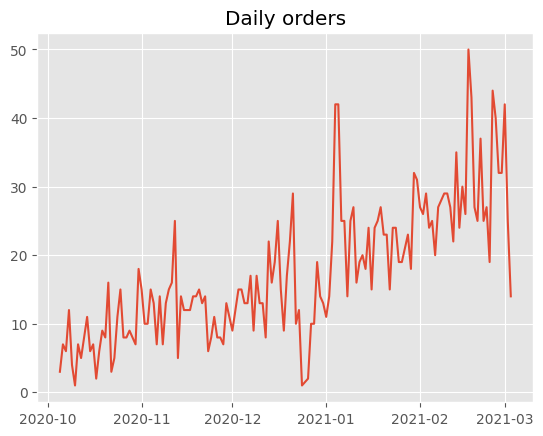

In [12]:
daily_orders = df_relevant.groupby("order_date").order_id.nunique()
plt.plot(daily_orders, label="Daily orders")
plt.title("Daily orders")

In [16]:
df_relevant["outcome"].value_counts(normalize=True)

outcome
0.0    0.985522
1.0    0.014478
Name: proportion, dtype: float64

We notice that the target variable is extremely unbalanced. This should be kept in mind when choosing the evaluation metric.

# Project

## Splits

In [13]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()

train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Train since:", cumsum_daily_orders.index.min())
print("Train until:", train_val_cutoff)
print("Val until:", val_test_cutoff)
print("Test until:", cumsum_daily_orders.index.max())

Train since: 2020-10-05
Train until: 2021-02-04
Val until: 2021-02-22
Test until: 2021-03-03


We have to keep in mind that our models won't capture stationary behavior, which could be considered for further temporal series models. 

Moreover, the split we have performed could be biased if one of the splits has a different distribution than the other, this could happen if the last split match with a special day, e.g., Christmas.

In [14]:
train = df_relevant[df_relevant.order_date <= train_val_cutoff]
val = df_relevant[
    (df_relevant.order_date > train_val_cutoff)
    & (df_relevant.order_date <= val_test_cutoff)
]
test = df_relevant[df_relevant.order_date > val_test_cutoff]

## Baseline model

In [41]:
def plot_metrics(model_name: str, y_pred: pd.Series, y_test: pd.Series) -> None:

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    average_precision = average_precision_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    ax[0].plot(
        recall,
        precision,
        label=f"{model_name} PR curve (auc = {average_precision:0.2f})",
    )
    ax[0].set_xlabel("Recall")
    ax[0].set_ylabel("Precision")
    ax[0].set_title("Precision-Recall curve")
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(fpr, tpr, label=f"{model_name} ROC curve (auc = {roc_auc:0.2f})")
    ax[1].plot([0, 1], [0, 1], "k--", label="Random")
    ax[1].set_xlabel("False positive rate")
    ax[1].set_ylabel("True positive rate")
    ax[1].set_title("ROC curve")
    ax[1].legend()
    ax[1].grid()
    plt.show()


def feature_label_split(
    df: pd.DataFrame, label_col: str
) -> tuple[pd.DataFrame, pd.Series]:
    X = df.drop(label_col, axis=1)
    y = df[label_col]
    return X, y


def model_metrics(
    model_name: str, y_true: pd.Series, y_pred: pd.Series
) -> tuple[float, float, float]:
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    average_precision = average_precision_score(y_true, y_pred)
    max_f1 = np.max(2 * precision * recall / (precision + recall))
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    print(
        f"{model_name}:\t PR curve auc = {average_precision:0.5f}.\t Best F1 score: {max_f1:0.5f}.\t ROC curve auc = {roc_auc:0.5f}."
    )
    return average_precision, max_f1, roc_auc


def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns=["features", "importance"]
    ).sort_values(by="importance", ascending=True)
    fi.plot(kind="barh", x="features", y="importance", ax=ax)
    return fi, fig, ax

In [19]:
X_train, y_train = feature_label_split(train, label_col)
X_val, y_val = feature_label_split(val, label_col)
X_test, y_test = feature_label_split(test, label_col)

We are going to use a simple linear model (logistic regression) as a baseline, based on the `global_popularity` feature.

In [23]:
feature = "global_popularity"

baseline_model = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="l2", C=1.0)
)

baseline_model.fit(X_train[[feature]], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

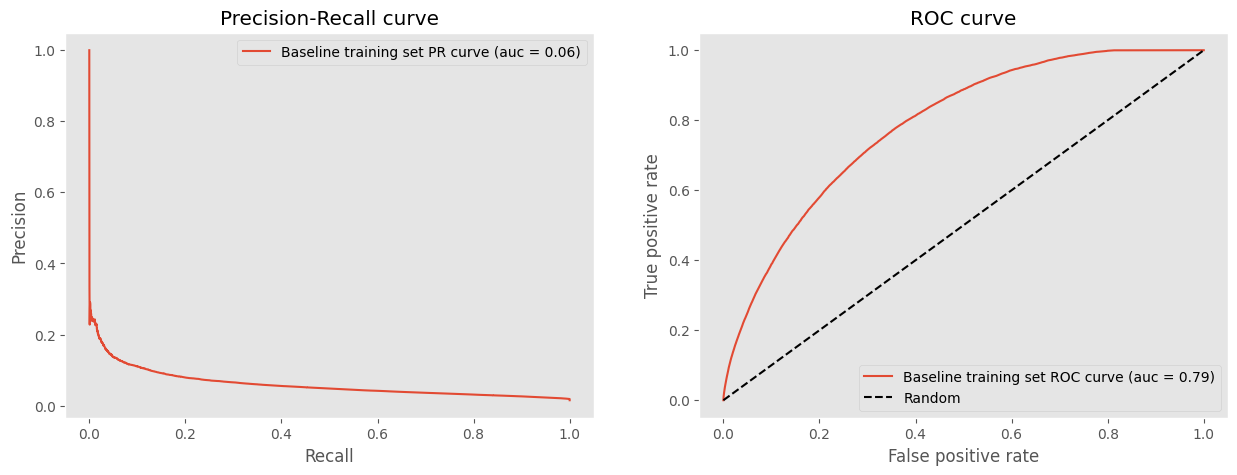

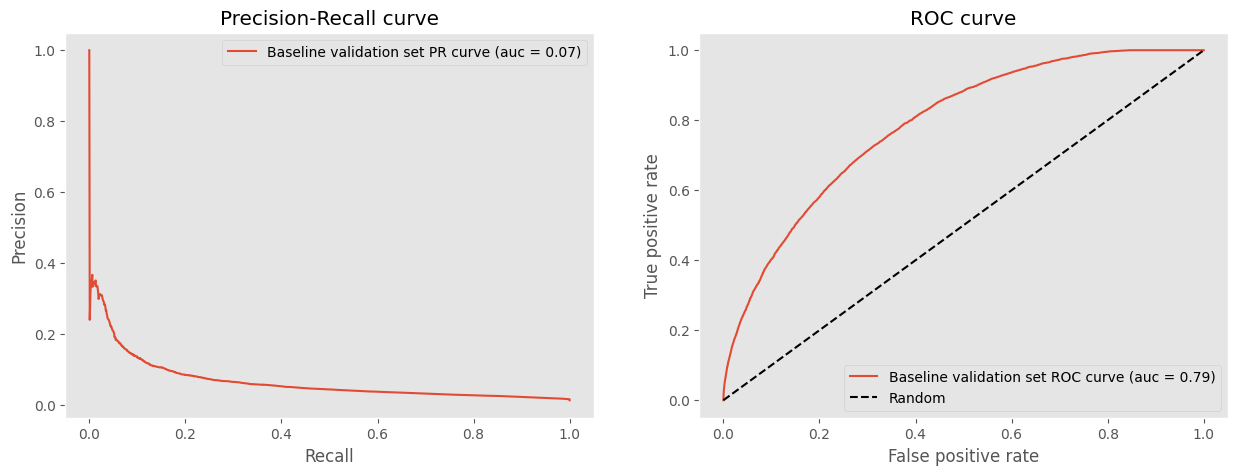

In [25]:
train_prob = baseline_model.predict_proba(X_train[[feature]])[:, 1]
plot_metrics("Baseline training set", train_prob, y_train)

val_prob = baseline_model.predict_proba(X_val[[feature]])[:, 1]
plot_metrics("Baseline validation set", val_prob, y_val)

## Non-linear Models

In [27]:
train_cols = numerical_cols + binary_cols  # leave out categorical columns

In [33]:
history = {}

n_trees = [5, 25, 50, 100]
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n)
    rf.fit(X_train[train_cols], y_train)
    val_prob = rf.predict_proba(X_val[train_cols])[:, 1]

    history[n] = model_metrics(f"Random Forest n={n} validation set", y_val, val_prob)

print(history)

Random Forest n=5 validation set:	 PR curve auc = 0.07204.	 Best F1 score: 0.17073.	 ROC curve auc = 0.64250.
Random Forest n=25 validation set:	 PR curve auc = 0.11133.	 Best F1 score: 0.19530.	 ROC curve auc = 0.71851.
Random Forest n=50 validation set:	 PR curve auc = 0.12251.	 Best F1 score: 0.19497.	 ROC curve auc = 0.73376.
Random Forest n=100 validation set:	 PR curve auc = 0.12573.	 Best F1 score: 0.19916.	 ROC curve auc = 0.75015.
{5: (0.07203687420522621, 0.17073362102785408, 0.6424986811891702), 25: (0.11132640273698625, 0.195297408912276, 0.7185063855447764), 50: (0.12250798753103241, 0.19496664645239536, 0.7337634663215015), 100: (0.12572895600587977, 0.19916083916083915, 0.7501471662207085)}


The best RF model was the one with 100 trees

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train[train_cols], y_train)

(                            features  importance
 6                       count_babies    0.001028
 17                    active_snoozed    0.004735
 4                       count_adults    0.005637
 5                     count_children    0.005865
 18                    set_as_regular    0.007120
 8                     people_ex_baby    0.007630
 7                         count_pets    0.011562
 13      avg_days_to_buy_product_type    0.019504
 14      std_days_to_buy_product_type    0.026635
 1                   normalised_price    0.033636
 15                    ordered_before    0.034747
 2                       discount_pct    0.037252
 10        avg_days_to_buy_variant_id    0.037964
 11        std_days_to_buy_variant_id    0.044750
 16                  abandoned_before    0.044998
 9     days_since_purchase_variant_id    0.046368
 0                     user_order_seq    0.118143
 12  days_since_purchase_product_type    0.144422
 3                  global_popularity    0.368003,

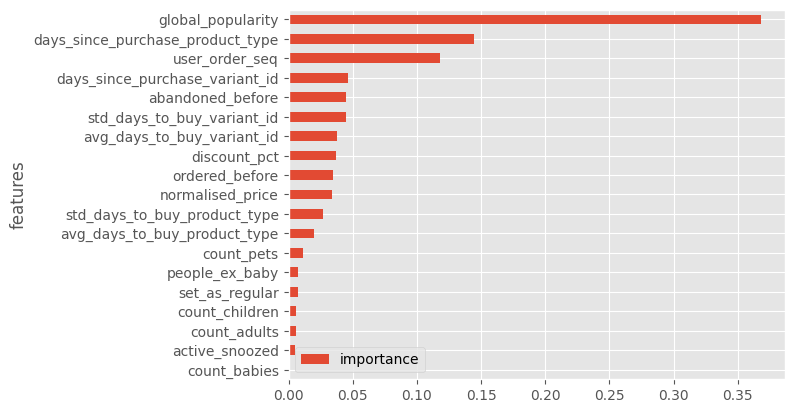

In [42]:
plot_feature_importance(rf, train_cols)

In [48]:
n_estimators = [20, 50, 100]
learning_rate = [0.1, 0.05]

history = {}

for n in n_estimators:
    for lr in learning_rate:
        gb = GradientBoostingClassifier(n_estimators=n, learning_rate=lr)
        gb.fit(X_train[train_cols], y_train)
        val_prob = gb.predict_proba(X_val[train_cols])[:, 1]
        history[(n, lr)] = model_metrics(
            f"Gradient Boosting n={n} lr={lr} validation set", y_val, val_prob
        )

Gradient Boosting n=20 lr=0.1 validation set:	 PR curve auc = 0.18212.	 Best F1 score: 0.26614.	 ROC curve auc = 0.84133.
Gradient Boosting n=20 lr=0.05 validation set:	 PR curve auc = 0.16421.	 Best F1 score: 0.25265.	 ROC curve auc = 0.82257.
Gradient Boosting n=50 lr=0.1 validation set:	 PR curve auc = 0.18737.	 Best F1 score: 0.27207.	 ROC curve auc = 0.84388.
Gradient Boosting n=50 lr=0.05 validation set:	 PR curve auc = 0.18644.	 Best F1 score: 0.27224.	 ROC curve auc = 0.84078.
Gradient Boosting n=100 lr=0.1 validation set:	 PR curve auc = 0.18766.	 Best F1 score: 0.27428.	 ROC curve auc = 0.84626.
Gradient Boosting n=100 lr=0.05 validation set:	 PR curve auc = 0.19093.	 Best F1 score: 0.27657.	 ROC curve auc = 0.84395.


The GBT model that performed best was the one with 100 trees, a learning rate of 0.05.

In [ ]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.05)
gb.fit(X_train[train_cols], y_train)

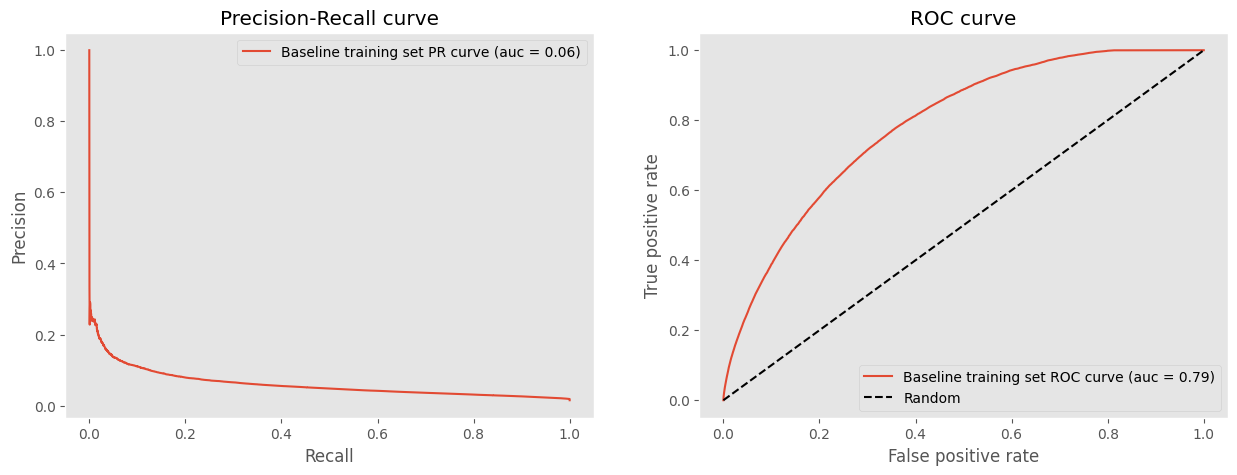

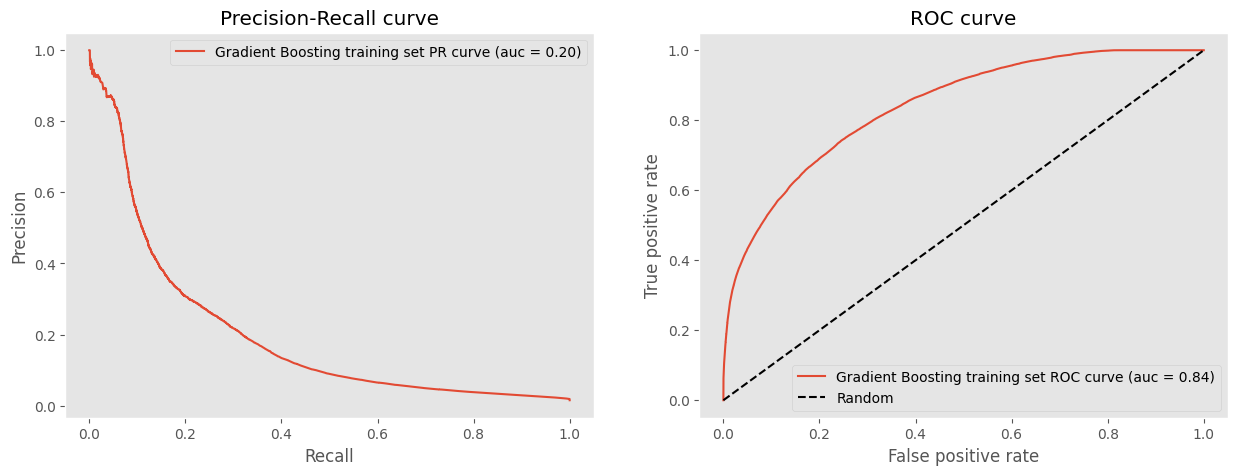

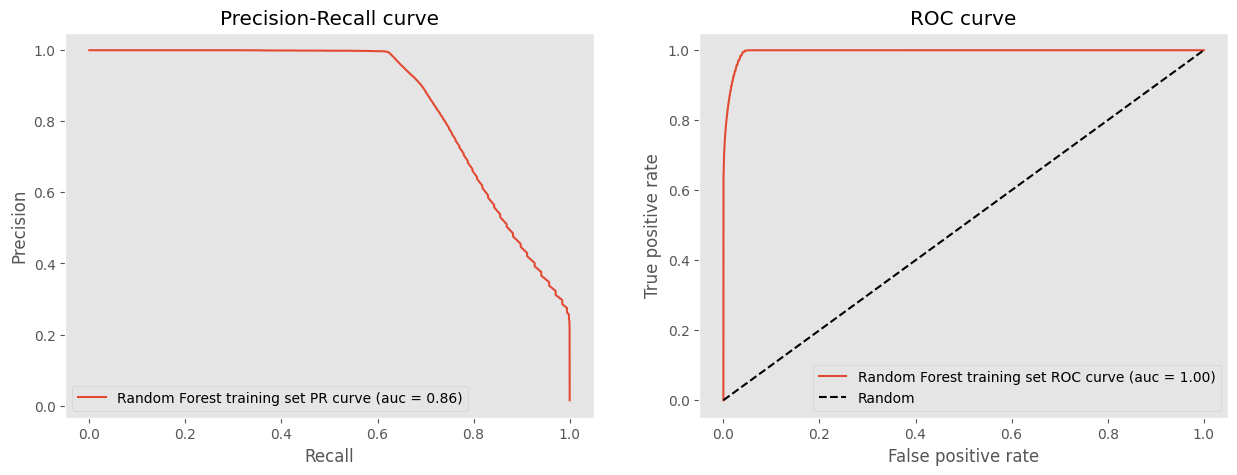

In [50]:
plot_metrics(
    "Baseline training set",
    baseline_model.predict_proba(X_train[[feature]])[:, 1],
    y_train,
)

plot_metrics(
    "Gradient Boosting training set",
    gb.predict_proba(X_train[train_cols])[:, 1],
    y_train,
)

plot_metrics(
    "Random Forest training set", rf.predict_proba(X_train[train_cols])[:, 1], y_train
)

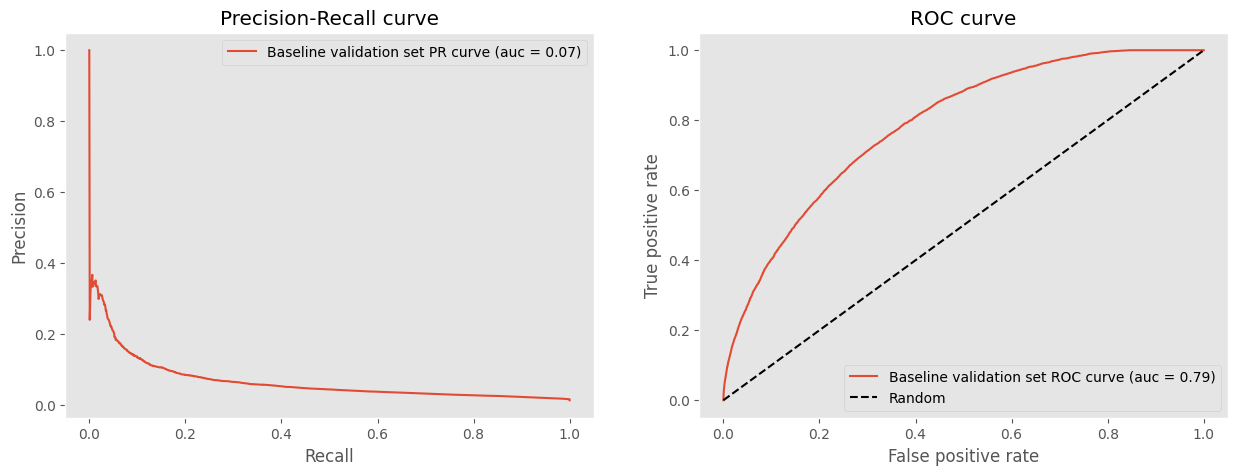

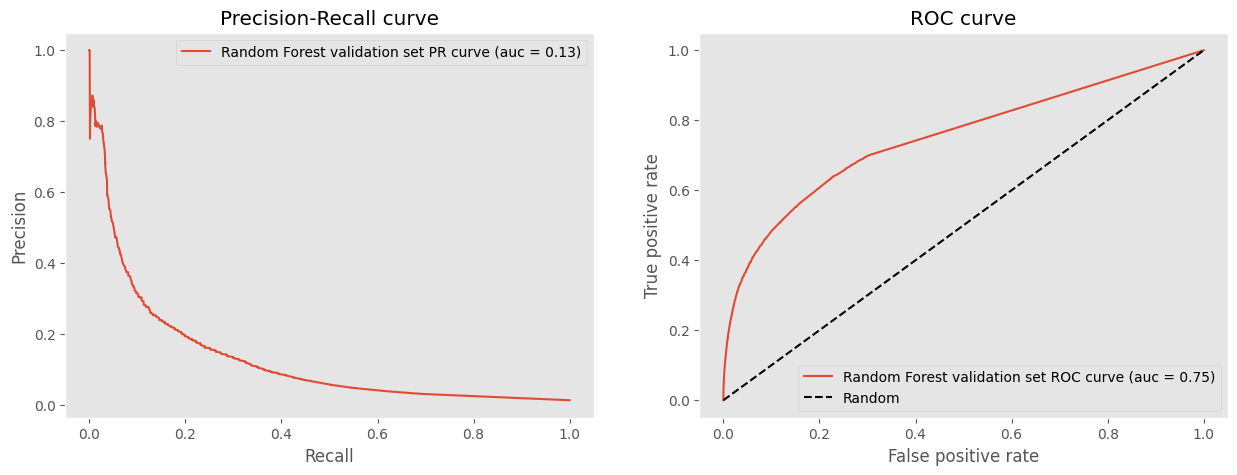

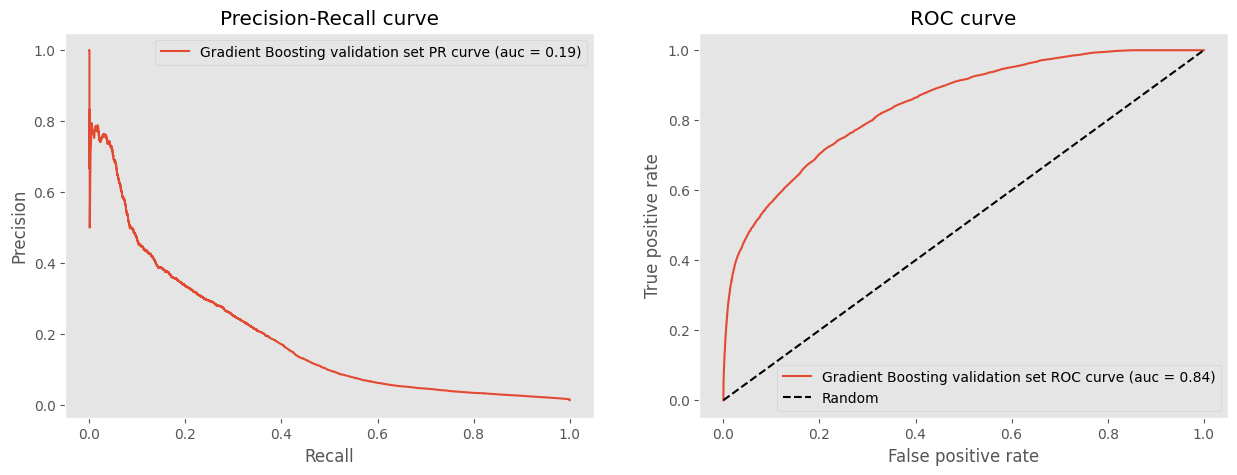

In [52]:
plot_metrics(
    "Baseline validation set",
    baseline_model.predict_proba(X_val[[feature]])[:, 1],
    y_val,
)

plot_metrics(
    "Random Forest validation set", rf.predict_proba(X_val[train_cols])[:, 1], y_val
)

plot_metrics(
    "Gradient Boosting validation set", gb.predict_proba(X_val[train_cols])[:, 1], y_val
)

In [53]:
def get_best_threshold(y_true: pd.Series, y_pred: pd.Series) -> float:
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    f1 = 2 * precision * recall / (precision + recall)
    return thresholds[np.argmax(f1)]

In [54]:
random_forest_val_pred = rf.predict_proba(X_val[train_cols])[:, 1]
random_forest_threshold = get_best_threshold(y_val, random_forest_val_pred)

gradient_boosting_val_pred = gb.predict_proba(X_val[train_cols])[:, 1]
gradient_boosting_threshold = get_best_threshold(y_val, gradient_boosting_val_pred)

In [59]:
def plot_confusion_matrix(
    model_name: str, y_true: pd.Series, y_pred: pd.Series, threshold: float
) -> None:

    fig, ax = plt.subplots()
    y_pred_binary = y_pred > threshold
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(f"{model_name} confusion matrix")
    plt.show()

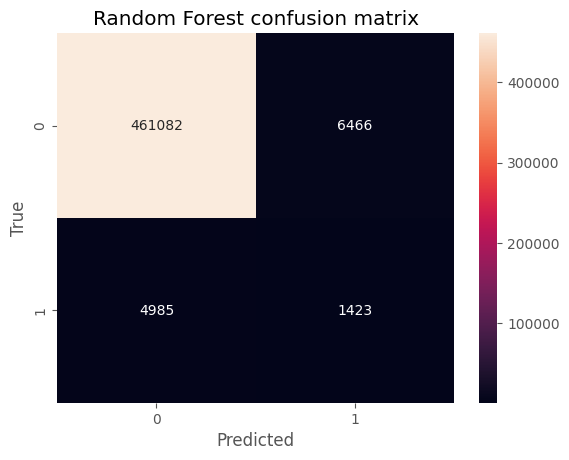

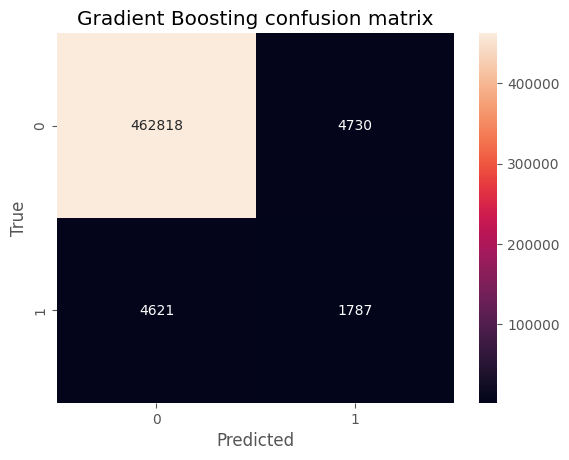

In [60]:
plot_confusion_matrix(
    "Random Forest", y_val, random_forest_val_pred, random_forest_threshold
)

plot_confusion_matrix(
    "Gradient Boosting", y_val, gradient_boosting_val_pred, gradient_boosting_threshold
)

In [61]:
accuracy_random_forest = (
    rf.predict_proba(X_val[train_cols])[:, 1] > random_forest_threshold
).mean()
accuracy_gradient_boosting = (
    gb.predict_proba(X_val[train_cols])[:, 1] > gradient_boosting_threshold
).mean()

print(f"Random Forest accuracy: {accuracy_random_forest:0.5f}")
print(f"Gradient Boosting accuracy: {accuracy_gradient_boosting:0.5f}")

Random Forest accuracy: 0.01665
Gradient Boosting accuracy: 0.01375


The RF model performed better than the GBT model.

# Test

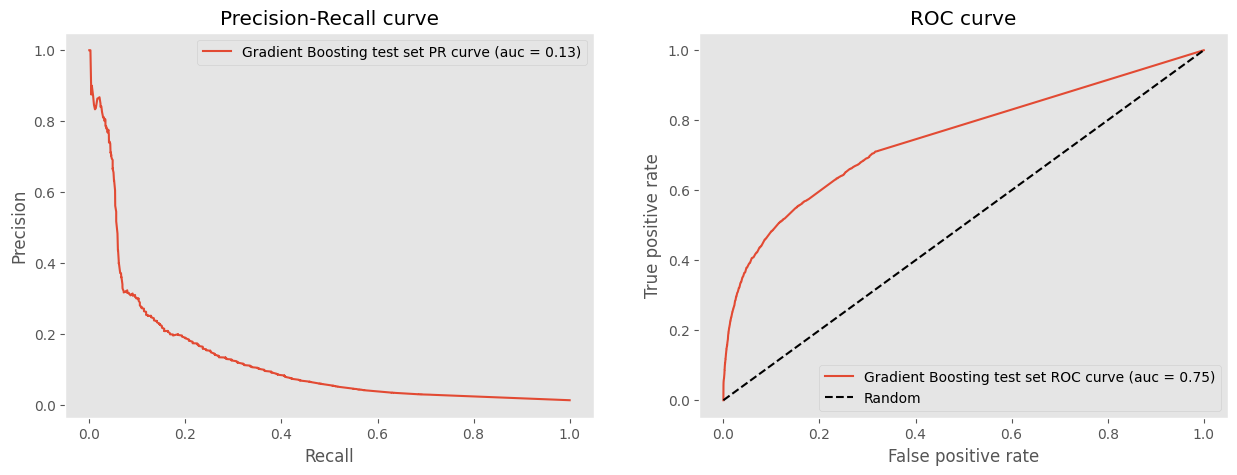

In [63]:
rf_test_pred = rf.predict_proba(X_test[train_cols])[:, 1]

plot_metrics("Gradient Boosting test set", rf_test_pred, y_test)

0.23


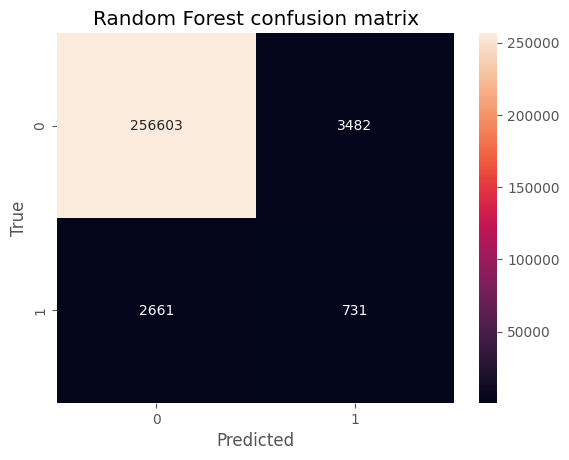

In [64]:
best_test_threshold = get_best_threshold(y_test, rf_test_pred)
print(best_test_threshold)
plot_confusion_matrix("Random Forest", y_test, rf_test_pred, best_test_threshold)

In [65]:
accuracy_rf_test = (
    rf.predict_proba(X_test[train_cols])[:, 1] > best_test_threshold
).mean()
accuracy_rf_test

0.01599001051325163

We are going to use a RF model